Nama : Aida Muhdina
</br>Email : aidamuhdina@gmail.com

In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
data = pd.read_csv('/content/drive/MyDrive/Colab machine learning/time series/city_temperature.csv')
data

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9
...,...,...,...,...,...,...,...,...
2906322,North America,US,Additional Territories,San Juan Puerto Rico,7,27,2013,82.4
2906323,North America,US,Additional Territories,San Juan Puerto Rico,7,28,2013,81.6
2906324,North America,US,Additional Territories,San Juan Puerto Rico,7,29,2013,84.2
2906325,North America,US,Additional Territories,San Juan Puerto Rico,7,30,2013,83.8


In [3]:
data = data.loc[(data.City == 'Washington')]
data = data.loc[(data.Year >= 2000) & (data.Year <= 2020)]
data

,Region,Country,State,City,Month,Day,Year,AvgTemperature
1670351,North America,US,District of Columbia,Washington,1,1,2000,43.4
1670352,North America,US,District of Columbia,Washington,1,2,2000,52.8
1670353,North America,US,District of Columbia,Washington,1,3,2000,58.2
1670354,North America,US,District of Columbia,Washington,1,4,2000,61.0
1670355,North America,US,District of Columbia,Washington,1,5,2000,44.1
...,...,...,...,...,...,...,...,...
1687050,North America,US,District of Columbia,Washington,5,9,2020,45.2
1687051,North America,US,District of Columbia,Washington,5,10,2020,50.2
1687052,North America,US,District of Columbia,Washington,5,11,2020,56.1
1687053,North America,US,District of Columbia,Washington,5,12,2020,52.5


In [4]:
#menggabungkan kolom "month", "day", "year" menjadi "date"
data['Date'] = pd.to_datetime(data.loc[:,('Year', 'Month', 'Day')], format='%Y%m%d')
data

,Region,Country,State,City,Month,Day,Year,AvgTemperature,Date
1670351,North America,US,District of Columbia,Washington,1,1,2000,43.4,2000-01-01
1670352,North America,US,District of Columbia,Washington,1,2,2000,52.8,2000-01-02
1670353,North America,US,District of Columbia,Washington,1,3,2000,58.2,2000-01-03
1670354,North America,US,District of Columbia,Washington,1,4,2000,61.0,2000-01-04
1670355,North America,US,District of Columbia,Washington,1,5,2000,44.1,2000-01-05
...,...,...,...,...,...,...,...,...,...
1687050,North America,US,District of Columbia,Washington,5,9,2020,45.2,2020-05-09
1687051,North America,US,District of Columbia,Washington,5,10,2020,50.2,2020-05-10
1687052,North America,US,District of Columbia,Washington,5,11,2020,56.1,2020-05-11
1687053,North America,US,District of Columbia,Washington,5,12,2020,52.5,2020-05-12


In [5]:
#menghapus kolom yang tidak diperlukan
data.drop(['Region', 'State', 'City', 'Country','Year','Month', 'Day'], axis=1, inplace=True)
data

,AvgTemperature,Date
1670351,43.4,2000-01-01
1670352,52.8,2000-01-02
1670353,58.2,2000-01-03
1670354,61.0,2000-01-04
1670355,44.1,2000-01-05
...,...,...
1687050,45.2,2020-05-09
1687051,50.2,2020-05-10
1687052,56.1,2020-05-11
1687053,52.5,2020-05-12


In [6]:
data.AvgTemperature.replace(-99, np.NaN, inplace=True)
data.AvgTemperature.ffill(inplace=True)
data.sort_values(by='AvgTemperature', ascending=True)

,AvgTemperature,Date
1675880,12.9,2015-02-20
1685145,12.9,2015-02-20
1684736,13.7,2014-01-07
1675471,13.7,2014-01-07
1686586,14.0,2019-01-31
...,...,...
1674923,92.4,2012-07-08
1674922,92.6,2012-07-07
1684187,92.6,2012-07-07
1674572,92.6,2011-07-23


Text(0.5, 1.0, 'Average Temperature')

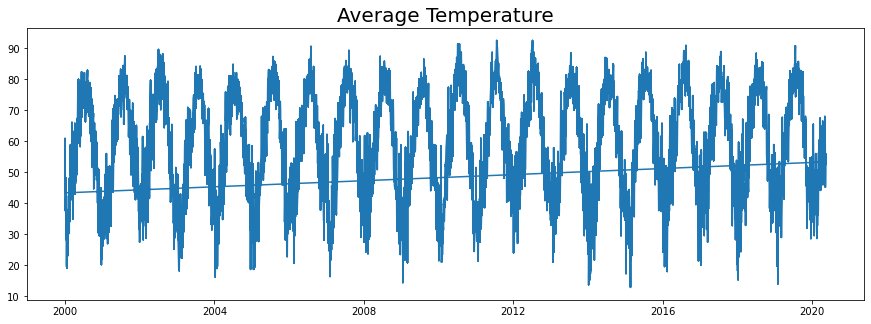

In [7]:
# #membuat plot dataset
date = data['Date'].values
average_temp = data['AvgTemperature'].values

plt.figure(figsize=(15, 5))
plt.plot(date, average_temp)
plt.title('Average Temperature', fontsize=20)

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [9]:
train, val = train_test_split(average_temp, test_size=0.2, shuffle=False)

In [10]:
train_set = windowed_dataset(train, window_size=60, batch_size=100, shuffle_buffer=1000)
val_set = windowed_dataset(val, window_size=60, batch_size=100, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
            tf.keras.layers.LSTM(60, return_sequences=True),
            tf.keras.layers.LSTM(60),
            tf.keras.layers.Dense(10, activation='relu'),
            tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-05, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])

In [11]:
#membuat callback
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [12]:
history = model.fit(train_set, epochs=100, validation_data=val_set, callbacks=[early_stop], verbose=2)

Epoch 1/100
119/119 - 18s - loss: 57.2306 - mae: 57.7306 - val_loss: 57.9531 - val_mae: 58.4531
Epoch 2/100
119/119 - 12s - loss: 56.6683 - mae: 57.1683 - val_loss: 57.4878 - val_mae: 57.9878
Epoch 3/100
119/119 - 12s - loss: 56.2480 - mae: 56.7480 - val_loss: 57.0873 - val_mae: 57.5873
Epoch 4/100
119/119 - 12s - loss: 55.8665 - mae: 56.3665 - val_loss: 56.7305 - val_mae: 57.2305
Epoch 5/100
119/119 - 12s - loss: 55.5096 - mae: 56.0096 - val_loss: 56.3688 - val_mae: 56.8688
Epoch 6/100
119/119 - 13s - loss: 55.1373 - mae: 55.6373 - val_loss: 55.9851 - val_mae: 56.4851
Epoch 7/100
119/119 - 13s - loss: 54.7419 - mae: 55.2419 - val_loss: 55.5765 - val_mae: 56.0765
Epoch 8/100
119/119 - 12s - loss: 54.3183 - mae: 54.8183 - val_loss: 55.1357 - val_mae: 55.6357
Epoch 9/100
119/119 - 13s - loss: 53.8575 - mae: 54.3575 - val_loss: 54.6528 - val_mae: 55.1528
Epoch 10/100
119/119 - 12s - loss: 53.3501 - mae: 53.8501 - val_loss: 54.1187 - val_mae: 54.6187
Epoch 11/100
119/119 - 13s - loss: 52.7

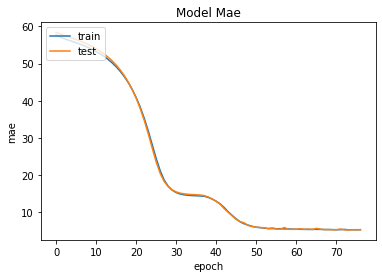

In [13]:
#plot mae
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

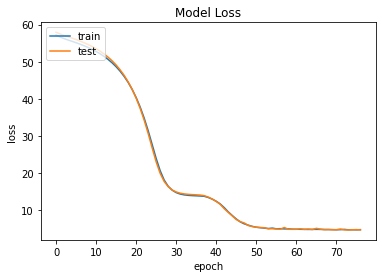

In [14]:
#plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()